In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import metpy
import cartopy.crs as ccrs
import glob
import geopandas as gpd
import os

from model_collection import ModelCollection

#https://stackoverflow.com/a/64823806/5217293
import joblib

from tqdm.notebook import tqdm

from IPython.display import HTML, display
from matplotlib import animation
import cartopy.feature as cfeature
import matplotlib 
import matplotlib.cm as cm
import string
matplotlib.rcParams['animation.embed_limit'] = 2**128

save_path = '/Users/kyle/GoogleDrive/College/Graduate/Thesis/Figures and Data/tuned_models'

In [2]:
mc = ModelCollection.__new__(ModelCollection)

In [3]:
mc.load('figures_and_data/trained-models-all_years.pcl')

# Predicting the Gridded Dataset

In [12]:
cols = ['AOD','lat','lon','u10','v10','d2m','t2m','lai_hv','lai_lv','skt','sp','tp','blh','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']

for year in range(2018, 2022):
    files = sorted(glob.glob(f'/Volumes/Canon/matched/{year}/*.nc'))
    
    pbar = tqdm(files)
    for day in pbar:
        pbar.set_description(day)
        with xr.open_dataset(day) as ds:
            ds.load()
        
        save_dir = f'/Volumes/Canon/predictions/{year}'
        save_path = os.path.join(save_dir, f'{pd.to_datetime(ds.time.item()).day_of_year:03}.nc')
        if os.path.exists(save_path):
            continue

        # prepare the data
        df = ds.isel(time=0).to_dataframe()
        df = df.reset_index().drop(columns=['n_snapshots', 'goes_imager_projection', 'PM25', 'AOD470', 'AE'])
        df.dropna(inplace=True)
        if df.shape[0] == 0:
            continue
        df['month'] = df.time.dt.month
        df.month = df.month.astype('category')
        df = pd.get_dummies(df[df.columns])
        for a in set(cols).difference(df.columns.tolist()):
            df[a] = np.full_like(df['AOD'], fill_value=0)

        # extract the columns needed for prediction
        data = df[list(cols)].to_numpy()

        preds = mc.predict(data)

        # set the output on the dataframe
        for model, pred in preds.items():
            df[model] = pred

        # form an xarray dataset that uses the same coordinates as ds
        preds = df[['x', 'y', 'time'] + list(preds.keys())].set_index(['time', 'y', 'x']).to_xarray()

        # assign
        attrs = {'long_name': 'Predicted PM2.5 Value', 'units': 'micrograms per cubic meter'}
        for var in preds.data_vars:
            ds[var] = preds[var]
            ds[var].attrs = attrs

        os.makedirs(save_dir, exist_ok=True)
        ds.to_netcdf(save_path)

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

# Mapping Gridded Dataset Predictions

In [4]:
models = ['Linear Regression','Polynomial','Bayesian Ridge','MLP','Random Forest','Extra Trees','XGBoost']

In [5]:
ds = xr.open_mfdataset(
    '/Volumes/Canon/predictions/2021/*.nc',
)

In [6]:
with xr.open_dataset('/Volumes/Canon/predictions/2021/001.nc') as one:
    one.load()
    
# with xr.open_dataset('/Users/kyle/Downloads/OR_ABI-L2-AODC-M6_G16_s20210411801068_e20210411803441_c20210411806227.nc') as one:
#     one.load()

# proj = one.metpy.parse_cf('AOD').metpy.cartopy_crs
# plate = ccrs.PlateCarree()
# equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)

In [37]:
for i in range(1,366):
    with xr.open_dataset(f'/Volumes/Canon/predictions/2021/{i:03}.nc') as one:
        one.load()
    if not np.all(np.diff(one.y.values) < 0):
        print(i, np.all(np.diff(one.y.values) < 0))
        one.reindex(y = one.y[::-1]).to_netcdf(f'/Volumes/Canon/predictions/2021/{i:03}.nc')

21 False
166 False
202 False


In [7]:
ds = ds[models]

In [8]:
def set_extent(ax, extents):
    minlon, maxlon = extents['minlon'], extents['maxlon']
    minlat, maxlat = extents['minlat'], extents['maxlat']
    ax.set_extent([minlon, maxlon, minlat, maxlat], ccrs.PlateCarree())
    
def add_ring(ax, extents):
    minlon, maxlon = extents['minlon'], extents['maxlon']
    minlat, maxlat = extents['minlat'], extents['maxlat']
    nvert = 100
    ring_lons = np.r_[np.linspace(minlon, minlon, nvert),
                 np.linspace(minlon, maxlon, nvert),
                 np.linspace(maxlon, maxlon, nvert)].tolist()
    ring_lats = np.r_[np.linspace(minlat, maxlat, nvert),
                 np.linspace(maxlat, maxlat, nvert),
                 np.linspace(maxlat, minlat, nvert)].tolist()

    ring = LinearRing(list(zip(ring_lons, ring_lats)))
    ax.add_geometries([ring], ccrs.PlateCarree(),
                       facecolor='none', edgecolor='red', linewidth=0.4)

def plot_cities(ax, extents, places=None, dx=0.05, dy=0.05, fontsize=8, show_population=False, markersize=5, alpha=1, color='red'):
    minlon, maxlon = extents['minlon'], extents['maxlon']
    minlat, maxlat = extents['minlat'], extents['maxlat']
    if places is None:
        places = gpd.read_file('data/Natural_Earth_quick_start/110m_cultural/ne_110m_populated_places.shp')
    sub = places[
        (places.geometry.x > minlon) & 
        (places.geometry.x < maxlon) &
        (places.geometry.y > minlat) &
        (places.geometry.y < maxlat)
    ]
    sub.plot(markersize=markersize, ax=ax, transform=plate, color=color, alpha=alpha)
    for x, y, label, pop in zip(sub.geometry.x, sub.geometry.y, sub.NAME, sub.POP_MAX):
        if show_population:
            label = f'{label}, {pop:,} people'
        ax.text(x=x+dx, y=y+dy, s=label, transform=plate, fontsize=fontsize)
        
def plot_roads(ax, extents, roads=None):
    minlon, maxlon = extents['minlon'], extents['maxlon']
    minlat, maxlat = extents['minlat'], extents['maxlat']
    if roads is None:
        roads = gpd.read_file('data/Natural_Earth_quick_start/10m_cultural/ne_10m_roads.shp')
    roads.plot(ax=ax, transform=plate, color='black', lw=0.1)
    
def read(file):
    df = pd.read_csv(file, parse_dates=['Date Local'])

    df.rename(columns = {
        'Date Local':'time', 
        'Arithmetic Mean': 'value',
        'Latitude': 'latitude',
        'Longitude': 'longitude'
    }, inplace = True)

    keep = ['latitude', 'longitude', 'time', 'value','Local Site Name', 'Address', 'State Name', 'County Name','City Name', 'POC']
    df.drop(columns=df.columns.difference(keep),inplace=True)

    df = df.loc[df.value >= 0]
    
    return df

In [9]:
extents = {
    'US': {
        'minlat': 25,
        'maxlat': 49,
        'minlon': -120,
        'maxlon': -73
    },
    'USBbox': {
        'minlat': 24.396308,
        'maxlat': 49.384358,
        'minlon': -124.848974,
        'maxlon': -66.885444
    },
    'Houston': {
        'minlat': 29.3,
        'maxlat': 30.08910587,
        'minlon': -95.81349756,
        'maxlon': -94.73398897
    },
    'LA' : {
        'minlat': 33.5,
        'maxlat': 34.2152144,
        'minlon': -117.8,
        'maxlon': -116.7522488
    },
    'Pittsburgh': {
        'minlat': 40.14211,
        'maxlat': 40.62940,
        'minlon': -80.29827,
        'maxlon': -79.46404
    },
    'Nebraska': {
        'minlat': 40.000102,
        'maxlat': 43.00037,
        'minlon': -104.053729,
        'maxlon': -95.317255
    },
    'Fargo': {
        'minlat': 46.35421,
        'maxlat': 47.34895,
        'minlon': -97.33842,
        'maxlon': -95.75006
    }
}

### Yearly Mean

In [11]:
yearly_mean = ds.resample(time='1Y').mean('time').compute()

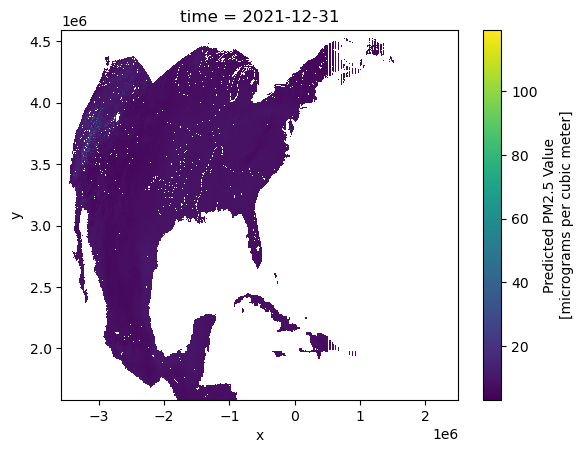

In [12]:
yearly_mean['Extra Trees'].plot()

In [13]:
yearly_mean['goes_imager_projection'] = one.goes_imager_projection

In [14]:
mapping = {'grid_mapping' : 'goes_imager_projection'}
yearly_mean['Linear Regression'].attrs = mapping
yearly_mean['Polynomial'].attrs = mapping
yearly_mean['Bayesian Ridge'].attrs = mapping
yearly_mean['MLP'].attrs = mapping
yearly_mean['Extra Trees'].attrs = mapping
yearly_mean['Random Forest'].attrs = mapping
yearly_mean['XGBoost'].attrs = mapping

In [15]:
yearly_mean

<xarray.Dataset>
Dimensions:                 (time: 1, y: 1500, x: 3471)
Coordinates:
  * y                       (y) float64 4.588e+06 4.586e+06 ... 1.584e+06
  * x                       (x) float64 -3.574e+06 -3.572e+06 ... 2.504e+06
    lat                     (y, x) float64 nan nan nan nan ... 14.8 14.8 14.81
    lon                     (y, x) float64 nan nan nan ... -50.47 -50.45 -50.43
  * time                    (time) datetime64[ns] 2021-12-31
Data variables:
    Linear Regression       (time, y, x) float64 nan nan nan nan ... nan nan nan
    Polynomial              (time, y, x) float64 nan nan nan nan ... nan nan nan
    Bayesian Ridge          (time, y, x) float64 nan nan nan nan ... nan nan nan
    MLP                     (time, y, x) float64 nan nan nan nan ... nan nan nan
    Random Forest           (time, y, x) float64 nan nan nan nan ... nan nan nan
    Extra Trees             (time, y, x) float64 nan nan nan nan ... nan nan nan
    XGBoost                 (time, y, x) float32 nan nan nan nan ... nan nan nan
    goes_imager_projection  int64 0

In [16]:
yearly_mean.to_netcdf(f'{save_path}/yearly_mean.nc')

In [17]:
proj = yearly_mean.metpy.parse_cf('Extra Trees').metpy.cartopy_crs
plate = ccrs.PlateCarree()
equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)

In [ ]:
with xr.open_dataset(f'{save_path}/yearly_mean.nc') as yearly_mean:
    yearly_mean.load()

In [27]:
df = yearly_mean.to_dataframe().reset_index().dropna().drop(['time', 'y', 'x', 'goes_imager_projection', 'lat', 'lon'], axis=1)
vmin, vmax = df.quantile(0.01).min(), df.quantile(0.99).max()


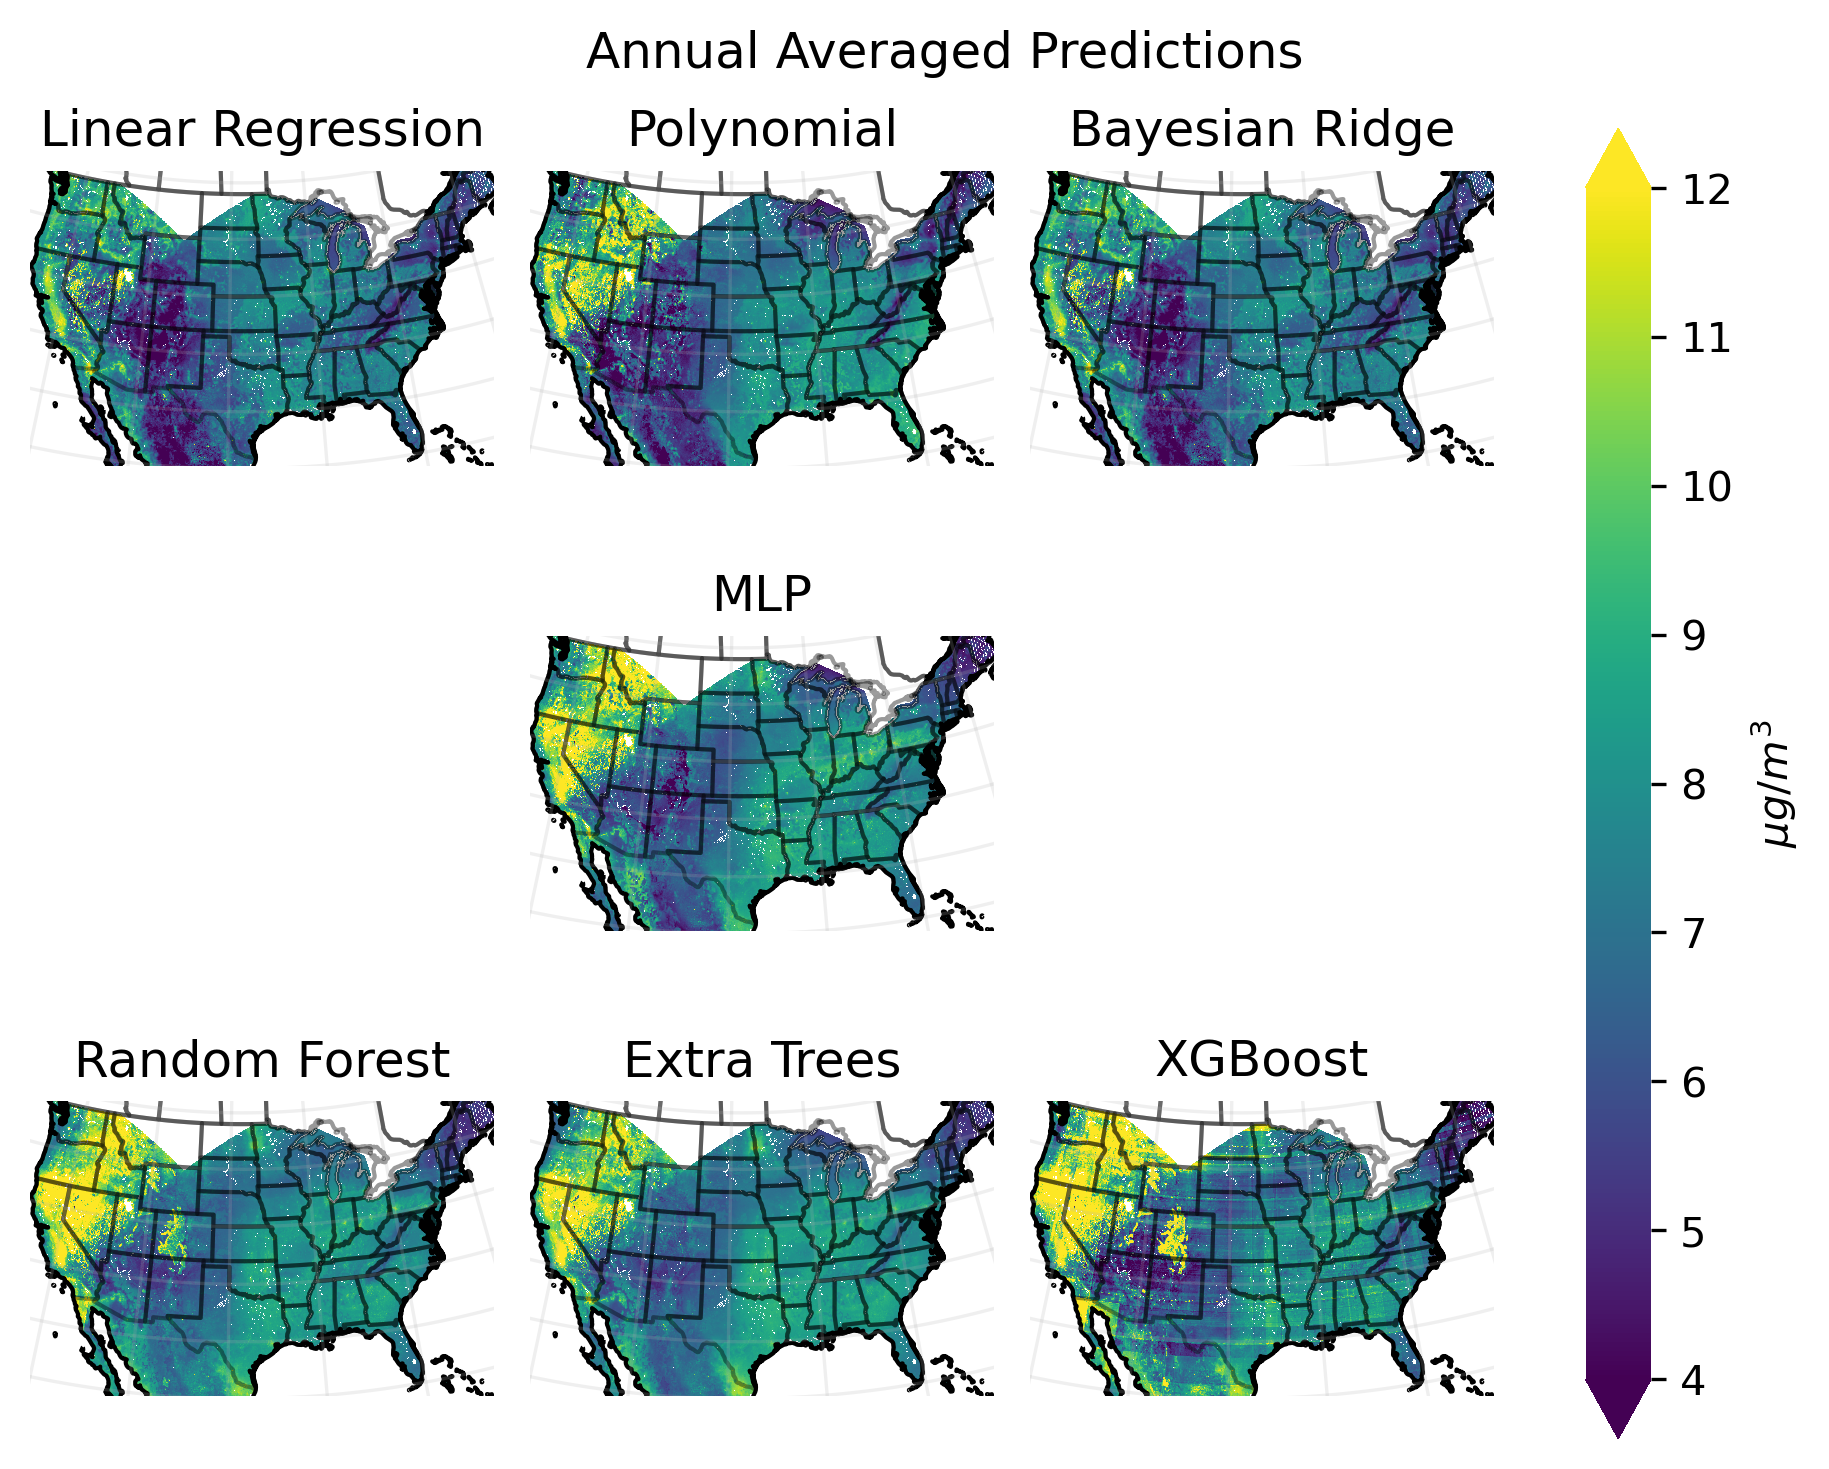

In [30]:
fig, axes = plt.subplots(3, 3, dpi=300, subplot_kw=dict(projection=equal_area))

axs = iter(axes.ravel())

for c in models:
    ax = next(axs)
    
    if c == 'MLP':
        ax.set_visible(False)
        ax = next(axs)
    
    a = yearly_mean[c].plot(ax=ax, transform=proj, 
                       vmin=4, 
                       vmax=12, 
                       add_colorbar=False)
    ax.coastlines()
    set_extent(ax, extents['US'])
    ax.set_title(c)
    ax.add_feature(cfeature.STATES, alpha=0.4)
    ax.spines[:].set_visible(False)
    
    ax.gridlines(alpha=0.2)
    
    if c == 'MLP':
        ax = next(axs)
        ax.set_visible(False)

fig.tight_layout()
cbar = fig.colorbar(a, ax=axes.ravel().tolist(), extend='both')
cbar.set_label('$\mu g / m^3$')
cbar.outline.set_linewidth(0)

for ax in axs:
    ax.set_visible(False)

fig.suptitle('Annual Averaged Predictions', y=1.01)
fig.savefig(f'{save_path}/annual-averages.png', format='png', bbox_inches = "tight")

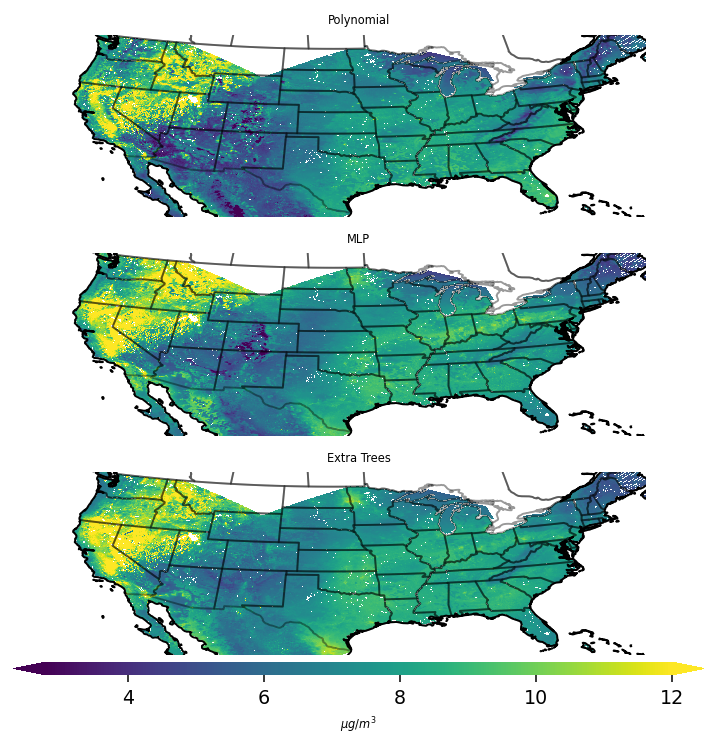

In [31]:
fig, axes = plt.subplots(3, 1, 
    figsize=(6.5,7),
#     figsize=set_size(345, subplots=(3,1)), 
    dpi=137, 
    subplot_kw=dict(projection=equal_area))

axs = iter(axes.ravel())

for c in ['Polynomial', 'MLP', 'Extra Trees']:
    ax = next(axs)
    
    a = yearly_mean[c].plot(ax=ax, transform=proj, 
                       vmin=vmin, 
                       vmax=12, 
                       add_colorbar=False)
    ax.coastlines()
    set_extent(ax, extents['US'])
    ax.set_title(c, fontsize=6)
    ax.add_feature(cfeature.STATES, alpha=0.4)
    ax.spines[:].set_visible(False)
    ax.set_aspect(0.5)

cbar = fig.colorbar(a, 
    ax=axes.ravel().tolist(), 
    extend='both', orientation='horizontal', 
    aspect=55, pad=0.01)
cbar.set_label('$\mu g / m^3$', fontsize=6)
cbar.outline.set_linewidth(0)

# fig.tight_layout()

# fig.suptitle('Annually Averaged Predictions', y=1.01, x=.6)
fig.savefig(f'{save_path}/annual-average-best-models.png', format='png', bbox_inches = "tight")

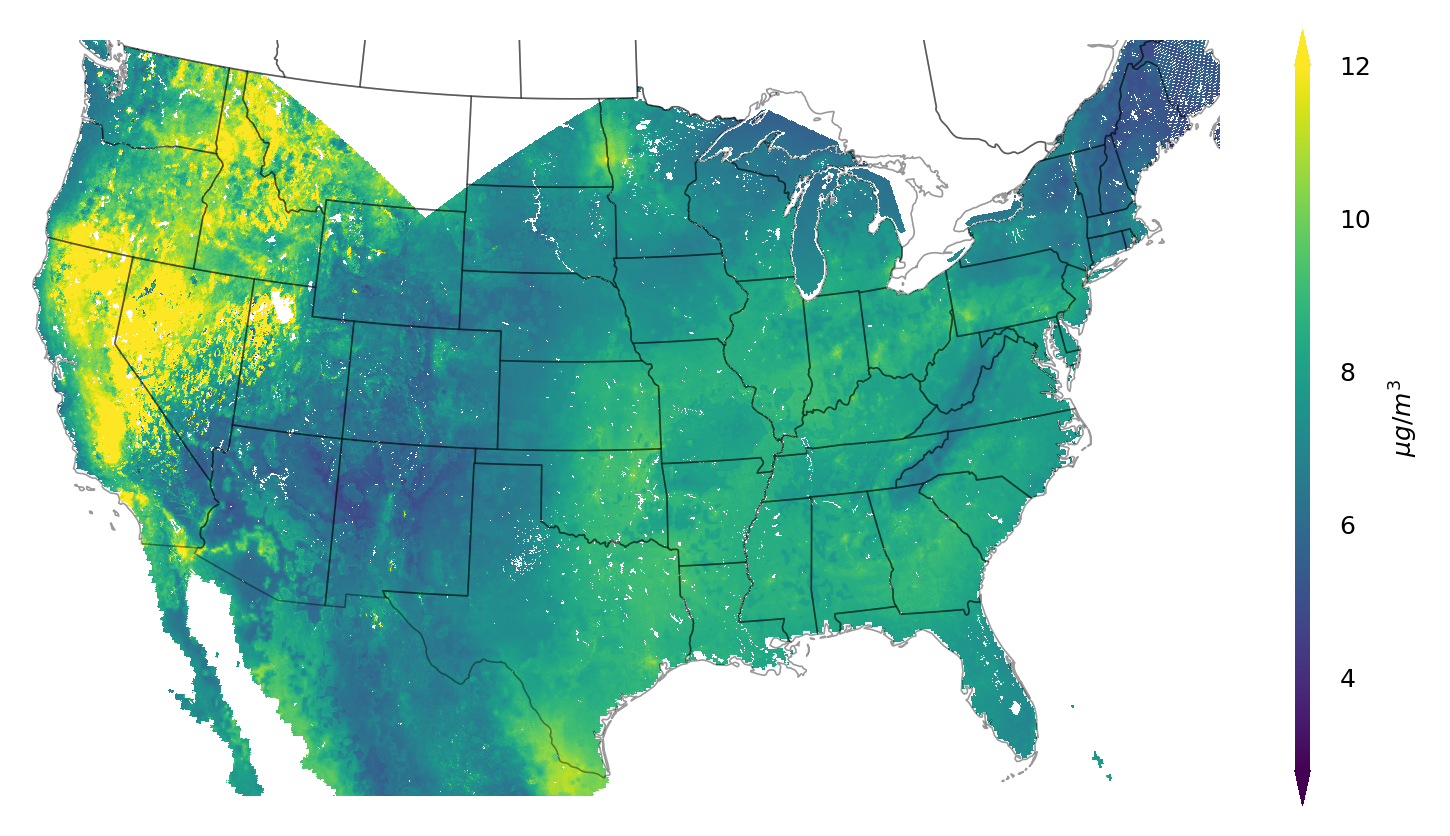

In [32]:
dpi=300
fig, ax = plt.subplots(
    dpi=dpi, 
#     figsize=set_size(345, subplots=(1,1)), 
    subplot_kw=dict(projection=equal_area)
)

a = yearly_mean['Extra Trees'].plot(ax=ax, transform=proj, vmin=vmin, vmax=12, add_colorbar=False)

ax.add_feature(cfeature.STATES, alpha=0.4, lw=0.4)
# ax.coastlines()
# ax.gridlines(alpha=0.3, lw=0.5)
ax.set_title('')

set_extent(ax, extents['US'])
ax.spines[:].set_visible(False)

cbar = fig.colorbar(a, ax=ax, extend='both', aspect=50, shrink=0.7)
cbar.ax.tick_params(labelsize=6, width=0)
cbar.set_label('$\mu g / m^3$', fontsize=6)
cbar.outline.set_linewidth(0)

fig.savefig(f'{save_path}/annual-average-extra_trees.png', format='png', bbox_inches = "tight")

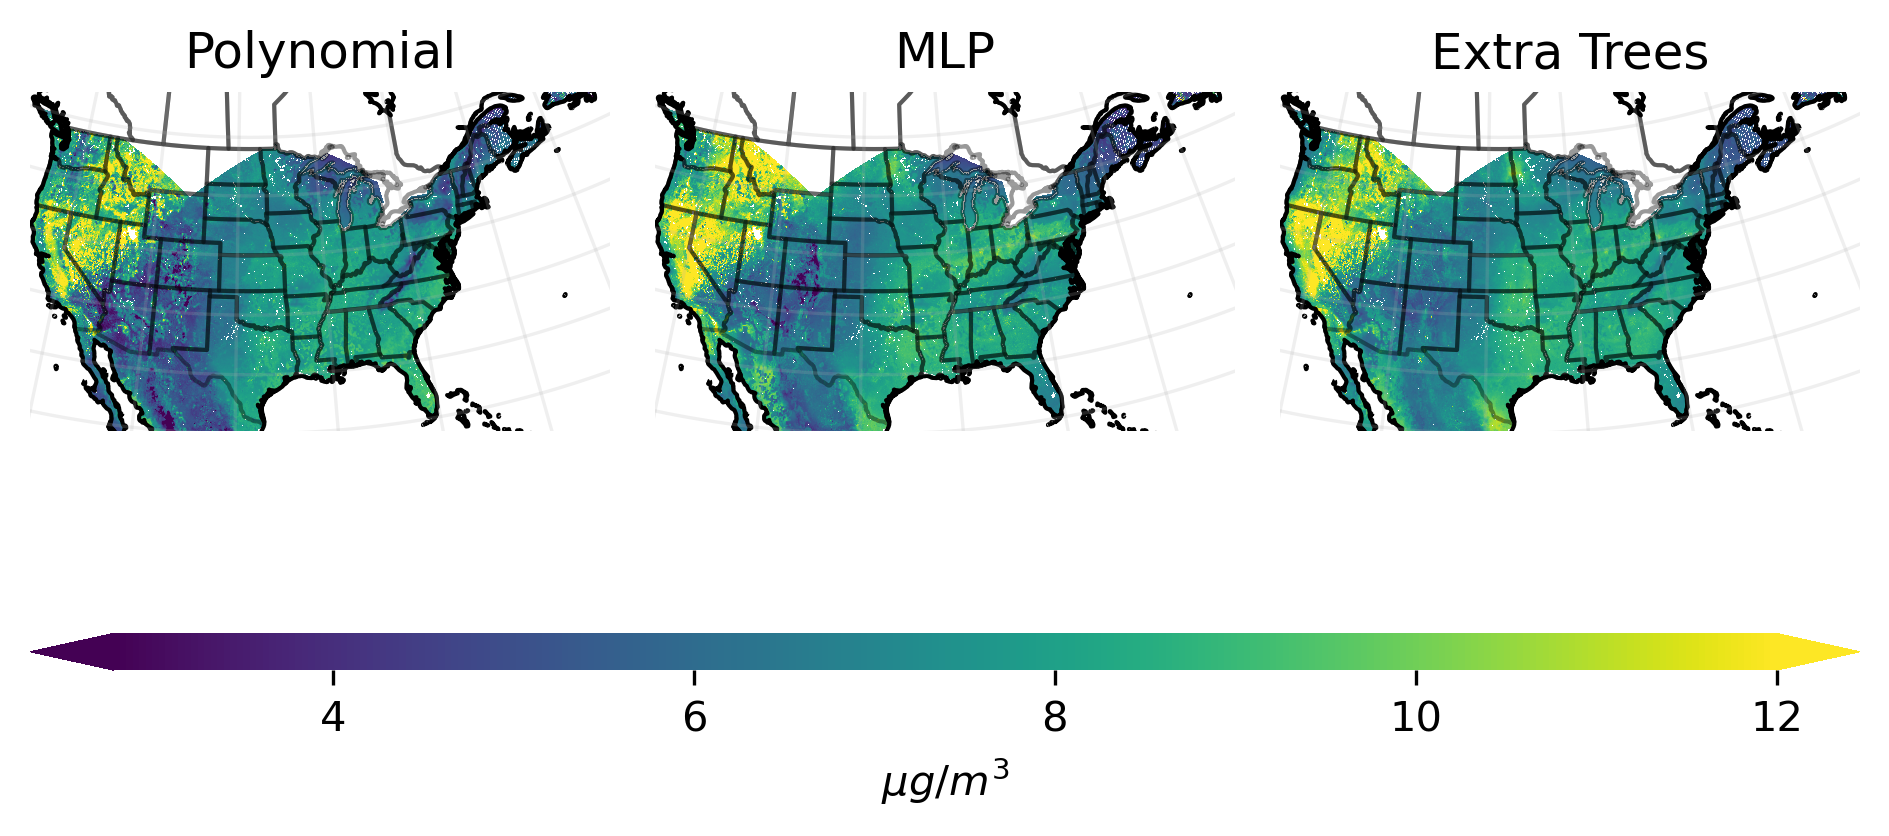

In [33]:
fig, axes = plt.subplots(1, 3, dpi=300, subplot_kw=dict(projection=equal_area))

axs = iter(axes.ravel())

vmin, vmax = df.quantile(0.01).min(), df.quantile(0.99).max()
for c in ['Polynomial', 'MLP', 'Extra Trees']:
    ax = next(axs)
    
    a = yearly_mean[c].plot(ax=ax, transform=proj, 
                       vmin=vmin, 
                       vmax=12, 
                       add_colorbar=False)
    ax.coastlines()
    ax.set_extent([-120, -63, 25, 50], plate)
    ax.set_title(c)
    ax.add_feature(cfeature.STATES, alpha=0.4)
    ax.spines[:].set_visible(False)
    
    ax.gridlines(alpha=0.2)
#     ax.set_aspect('auto')

fig.tight_layout()
cbar = fig.colorbar(a, ax=axes.ravel().tolist(), extend='both', orientation='horizontal', aspect=50)
cbar.set_label('$\mu g / m^3$')
cbar.outline.set_linewidth(0)

# fig.suptitle('Annually Averaged Predictions', y=.9, x=.5)
# fig.savefig(f'{save_path}/annual-average-best-models.png', format='png', bbox_inches = "tight")

### Extra Trees City Closeup

In [34]:
places = gpd.read_file('data/Natural_Earth_quick_start/10m_cultural/ne_10m_populated_places.shp')
roads = gpd.read_file('data/Natural_Earth_quick_start/10m_cultural/ne_10m_roads.shp')

In [35]:
zip_path = f'zip://data/houston_roads.zip!houston_roads/TRANSPORTATION_COMPLETE_STREETS.shp'
houston_roads = gpd.read_file(zip_path)

In [36]:
# minlon, maxlon, minlat, maxlat = -100, -90, 28, 30

brlat, brlon = 29.3,-94.73398897
tllat, tllon = 30.08910587,-95.81349756
minlon, maxlon, minlat, maxlat = tllon, brlon, brlat, tllat
sub = places[
    (places.geometry.x > minlon) & 
    (places.geometry.x < maxlon) &
    (places.geometry.y > minlat) &
    (places.geometry.y < maxlat)
]

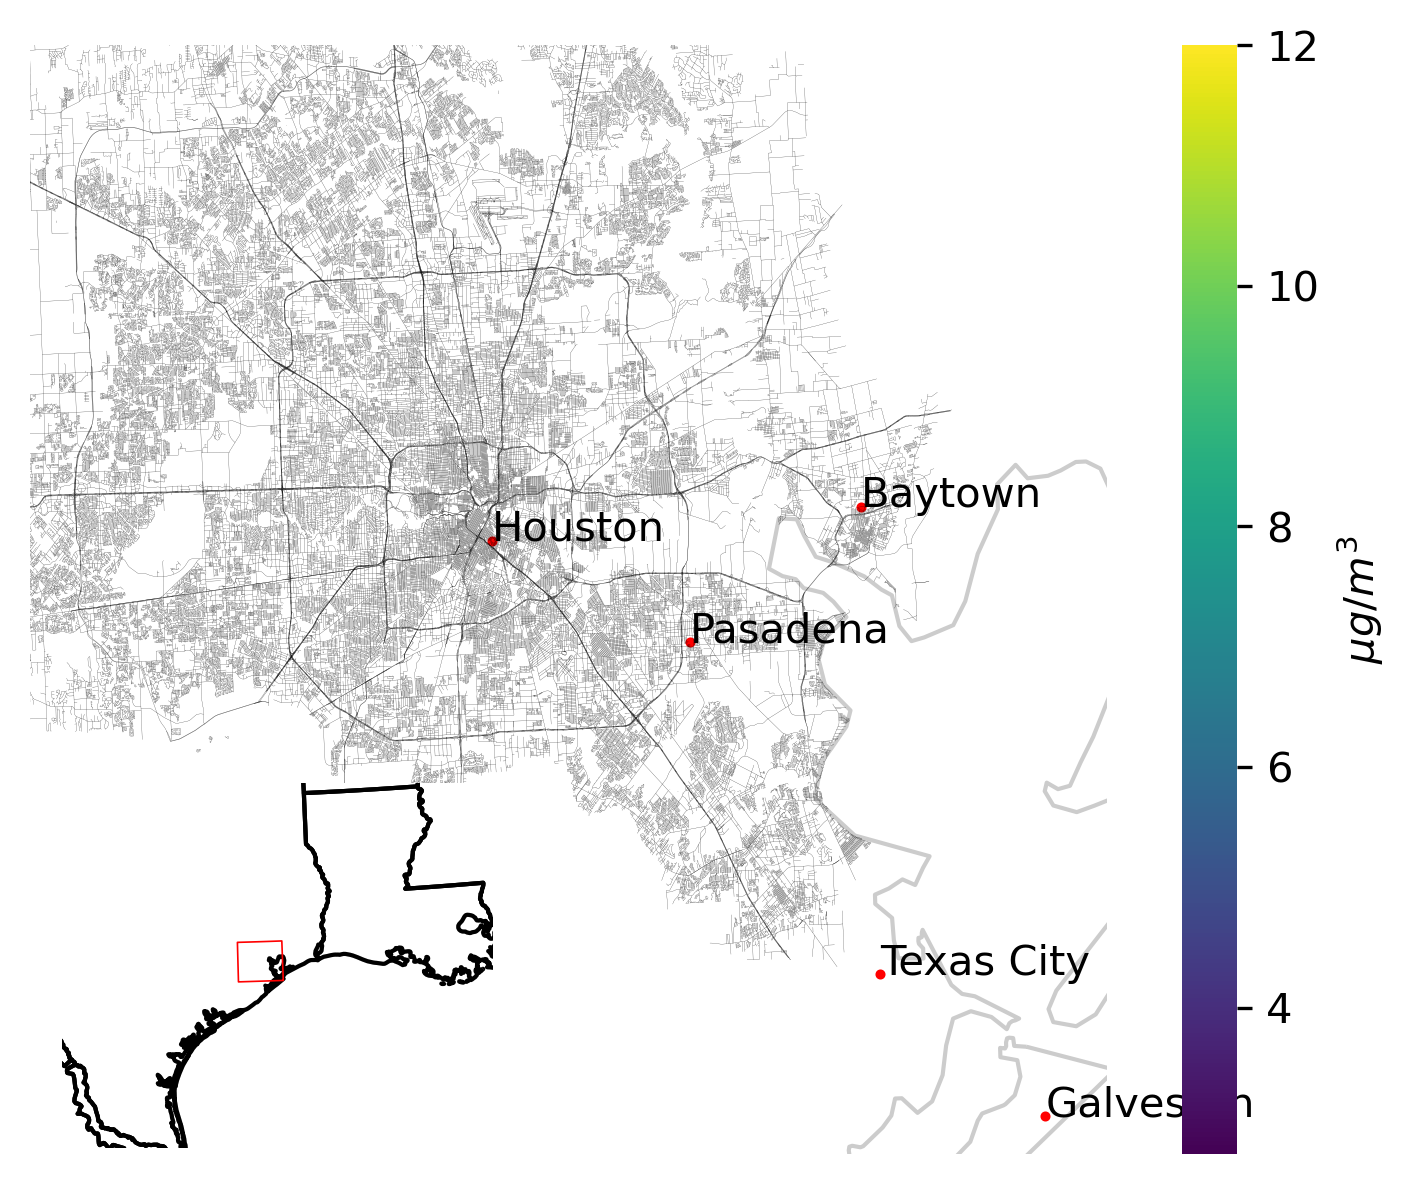

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from shapely.geometry.polygon import LinearRing

proj = equal_area
# the zoomed in plot
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=proj))

# the inset plot which shows the entire US with a rectangle highlighting the region of interest
ax2 = plt.axes([0, 0, 1, 1], projection=proj)
ax2.add_feature(cfeature.STATES)

inset_x = .23
inset_y = .17
inset_size = 0.4
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax2.set_axes_locator(ip)

a = yearly_mean['Extra Trees'].plot(
        ax=ax, transform=proj, vmin=vmin, vmax=12, 
        add_colorbar=False)

cbar = fig.colorbar(a, ax=ax)
cbar.outline.set_linewidth(0)
cbar.set_label('$\mu g / m^3$')

yearly_mean['Extra Trees'].plot(
        ax=ax2, transform=proj, vmin=vmin, vmax=12, 
        add_colorbar=False)
ax2.gridlines(alpha=0.3)

for axis in [ax, ax2]:
    axis.add_feature(cfeature.STATES, alpha=0.2)
    axis.spines[:].set_visible(False)
    axis.set_title('')

nvert = 100
ring_lons = np.r_[np.linspace(minlon, minlon, nvert),
             np.linspace(minlon, maxlon, nvert),
             np.linspace(maxlon, maxlon, nvert)].tolist()
ring_lats = np.r_[np.linspace(minlat, maxlat, nvert),
             np.linspace(maxlat, maxlat, nvert),
             np.linspace(maxlat, minlat, nvert)].tolist()

ring = LinearRing(list(zip(ring_lons, ring_lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.4)

sub.plot(markersize=2, ax=ax, transform=plate, color='red')
for x, y, label in zip(sub.geometry.x, sub.geometry.y, sub.NAME):
    ax.text(x=x, y=y, s=label, transform=plate, fontsize=10)

# roads.plot(ax=ax, transform=plate, color='black', lw=0.1)
houston_roads.plot(ax=ax, transform=plate, color='black', lw=0.05)    

ax.set_extent([minlon, maxlon, minlat, maxlat], plate)
ax2.set_extent([-100, -90, 26, 33], plate)

fig.savefig(f'{save_path}/houston-annual-average-extra-trees.png', format='png', bbox_inches = "tight")

In [39]:
places = gpd.read_file('data/Natural_Earth_quick_start/110m_cultural/ne_110m_populated_places.shp')
more_places = gpd.read_file('data/Natural_Earth_quick_start/10m_cultural/ne_10m_populated_places.shp')
roads = gpd.read_file('data/Natural_Earth_quick_start/10m_cultural/ne_10m_roads.shp')

In [40]:
pittsburgh = more_places[more_places.NAME == 'Pittsburgh']
fargo = more_places[more_places.NAME == 'Fargo']

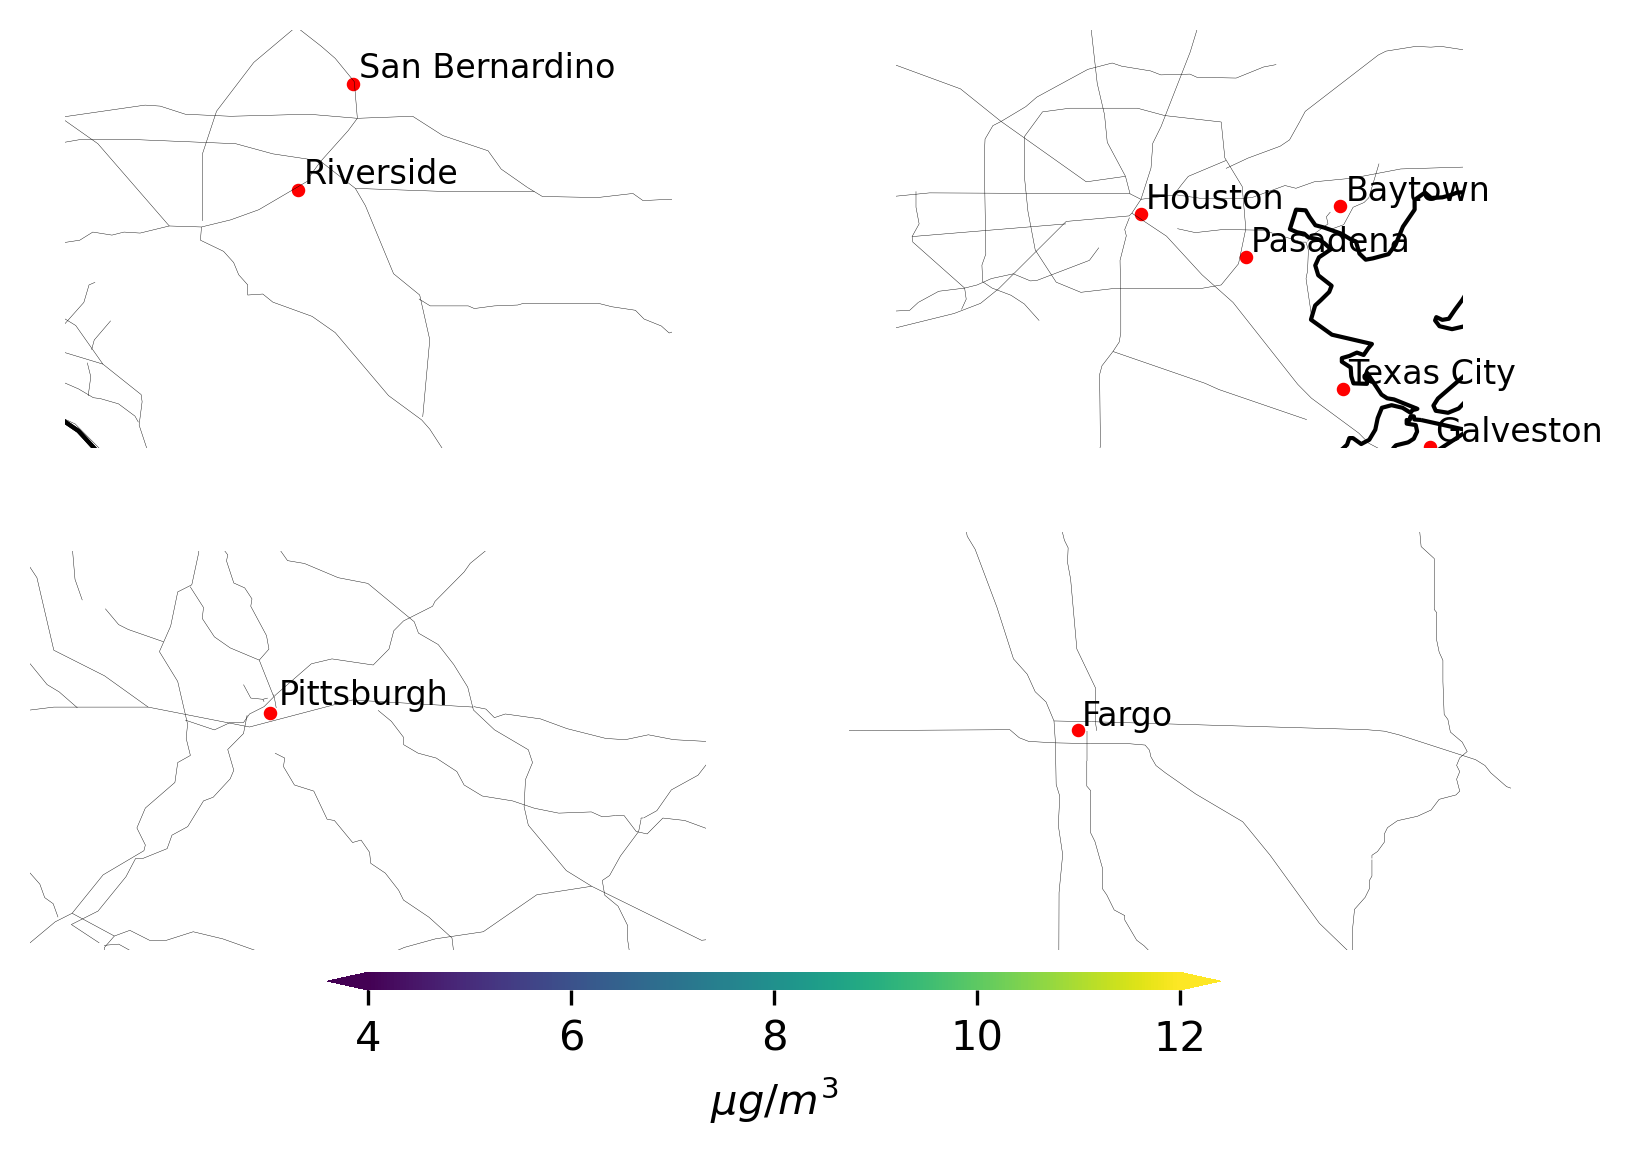

In [41]:
fig, axes = plt.subplots(2,2, dpi=300,
    subplot_kw=dict(projection=plate),
#     gridspec_kw=dict(wspace=-0.3, hspace=0.1),
)

(ax1, ax2, ax3, ax4) = axes.ravel()

for ax in axes.ravel():
    ax.coastlines()
    ax.gridlines(alpha=0.2)
    ax1.add_feature(cfeature.STATES, alpha=0.4)
    dat = yearly_mean['Extra Trees'].plot(
        ax=ax, transform=proj, vmin=4, vmax=12, 
        add_colorbar=False)
    ax.set_title('')
    ax.spines[:].set_visible(False)

# ax1.spines[['left', 'bottom']].set_visible(True)
    
plot_cities(ax1, extents['LA'], more_places, fontsize=8, dx=0.01, dy=0.01)
plot_cities(ax2, extents['Houston'], more_places, fontsize=8, dx=0.01, dy=0.01)
plot_cities(ax3, extents['Pittsburgh'], more_places, fontsize=8, dx=0.01, dy=0.01)
plot_cities(ax4, extents['Fargo'], fargo, fontsize=8, dx=0.01, dy=0.01)

plot_roads(ax1, extents['LA'], roads)
plot_roads(ax2, extents['Houston'], roads)
plot_roads(ax3, extents['Pittsburgh'], roads)
plot_roads(ax4, extents['Fargo'], roads)

set_extent(ax1, extents['LA'])
set_extent(ax2, extents['Houston'])
set_extent(ax3, extents['Pittsburgh'])
set_extent(ax4, extents['Fargo'])

cbar = fig.colorbar(dat, ax=axes, orientation='horizontal', aspect=50, shrink=0.6, pad=0.02, extend='both')
cbar.outline.set_linewidth(0)
cbar.set_label('$\mu g / m^3$')

# fig.tight_layout()

fig.savefig(f'{save_path}/cities-annual-average-extra-trees.png', format='png', bbox_inches = "tight")

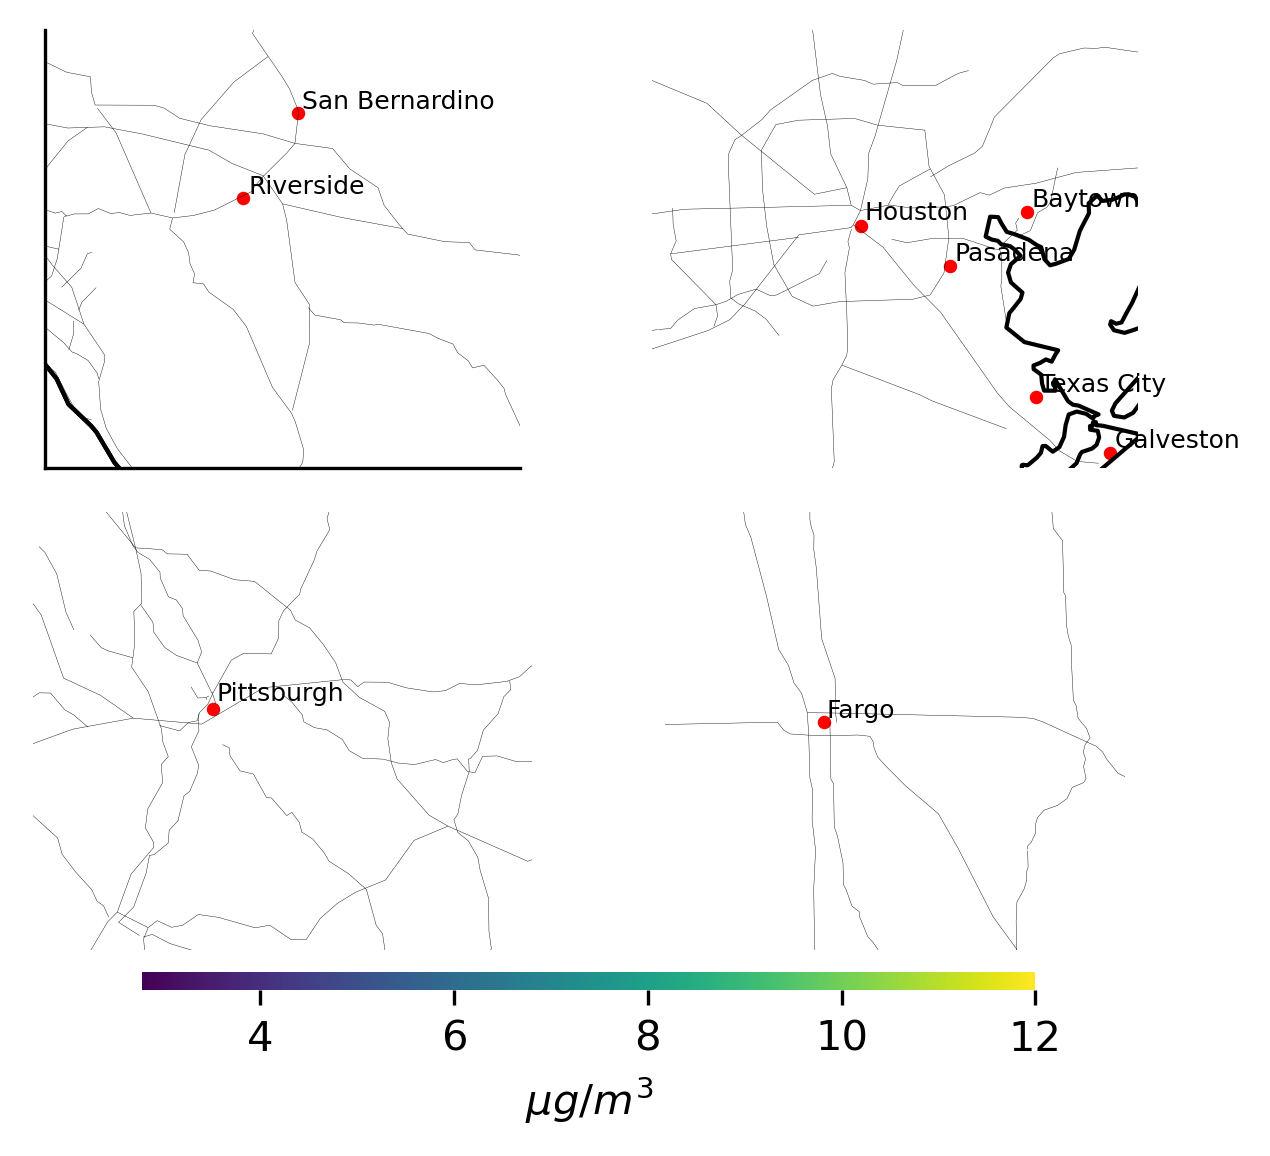

In [42]:
fig, axes = plt.subplots(2,2, dpi=300,
    subplot_kw=dict(projection=equal_area),
    gridspec_kw=dict(wspace=-0.3, hspace=0.1),
)

(ax1, ax2, ax3, ax4) = axes.ravel()

for ax in axes.ravel():
    ax.coastlines()
    ax.gridlines(alpha=0.2)
    ax1.add_feature(cfeature.STATES, alpha=0.4)
    dat = yearly_mean['Extra Trees'].plot(
        ax=ax, transform=proj, vmin=vmin, vmax=12, 
        add_colorbar=False)
    ax.set_title('')
    ax.spines[:].set_visible(False)

ax1.spines[['left', 'bottom']].set_visible(True)
    
plot_cities(ax1, extents['LA'], more_places, fontsize=6, dx=0.01, dy=0.01)
plot_cities(ax2, extents['Houston'], more_places, fontsize=6, dx=0.01, dy=0.01)
plot_cities(ax3, extents['Pittsburgh'], more_places, fontsize=6, dx=0.01, dy=0.01)
plot_cities(ax4, extents['Fargo'], fargo, fontsize=6, dx=0.01, dy=0.01)

plot_roads(ax1, extents['LA'], roads)
plot_roads(ax2, extents['Houston'], roads)
plot_roads(ax3, extents['Pittsburgh'], roads)
plot_roads(ax4, extents['Fargo'], roads)

set_extent(ax1, extents['LA'])
set_extent(ax2, extents['Houston'])
set_extent(ax3, extents['Pittsburgh'])
set_extent(ax4, extents['Fargo'])

cbar = fig.colorbar(dat, ax=axes, orientation='horizontal', aspect=50, shrink=0.6, pad=0.02)
cbar.outline.set_linewidth(0)
cbar.set_label('$\mu g / m^3$')

fig.savefig(f'{save_path}/cities-annual-average-extra-trees.png', format='png', bbox_inches = "tight")

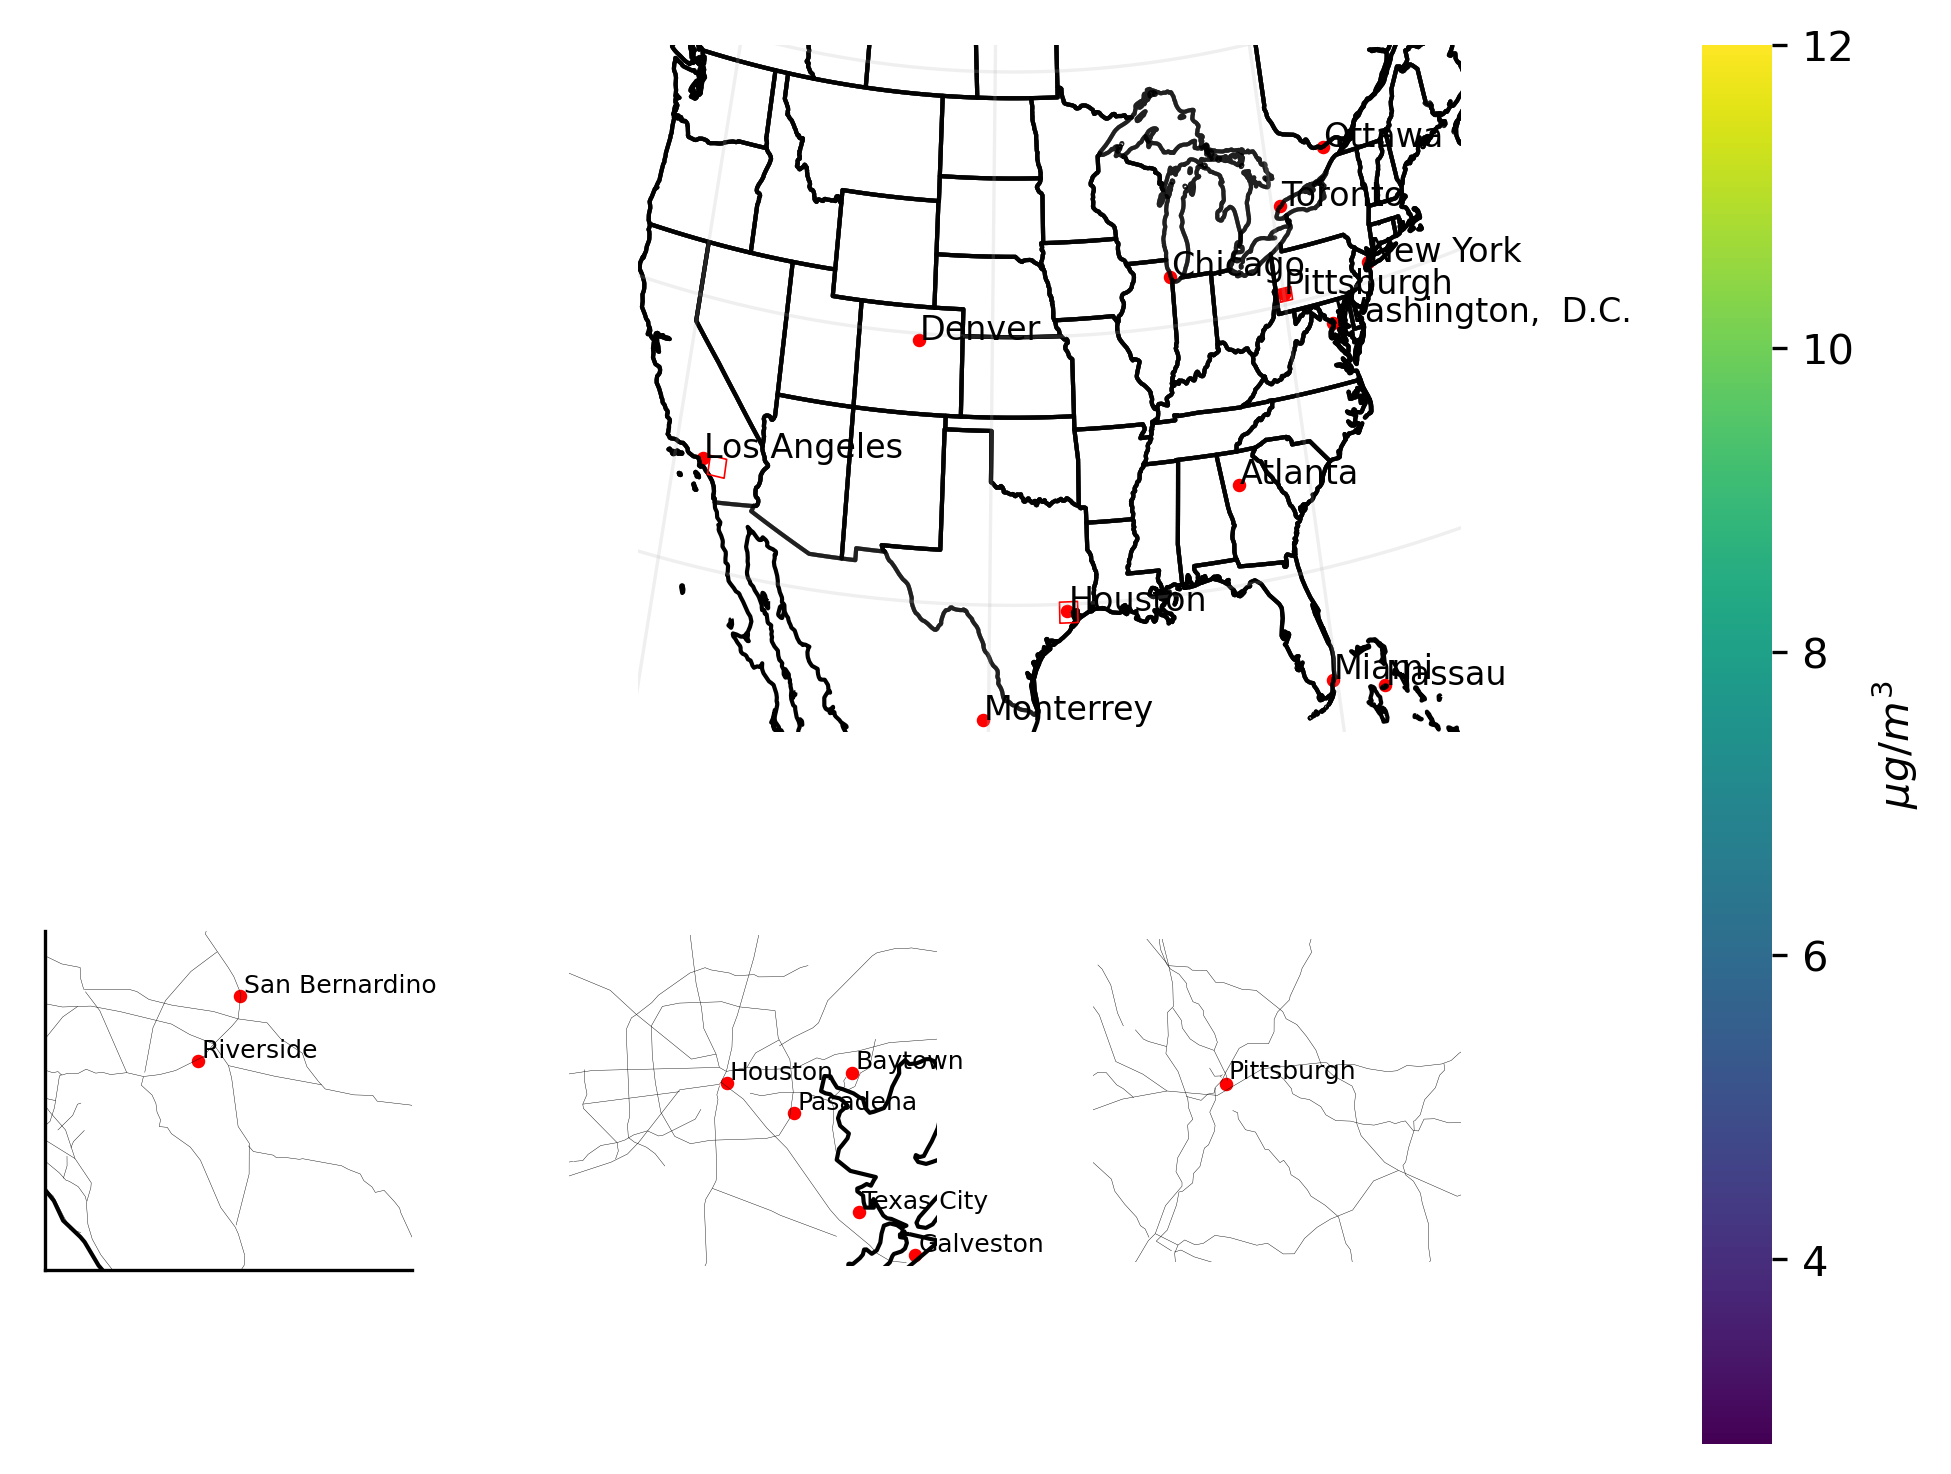

In [44]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(dpi=300, constrained_layout=True)

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :], projection=proj)
ax2 = fig.add_subplot(gs[-1, 0],  projection=equal_area)
ax3 = fig.add_subplot(gs[-1, 1],  projection=equal_area)
ax4 = fig.add_subplot(gs[-1, 2],  projection=equal_area)

axes = [ax1, ax2, ax3, ax4]


for ax in axes:
    ax.coastlines()
    ax.gridlines(alpha=0.2)
    ax1.add_feature(cfeature.STATES, alpha=0.4)
    dat = yearly_mean['Extra Trees'].plot(
        ax=ax, transform=proj, vmin=vmin, vmax=12, 
        add_colorbar=False)
    ax.set_title('')
    ax.spines[:].set_visible(False)
ax2.spines[['left', 'bottom']].set_visible(True)
    
plot_cities(ax1, extents['US'], places)
plot_cities(ax1, extents['US'], pittsburgh, dx=0.01, dy=0.01)
plot_cities(ax2, extents['LA'], more_places, fontsize=6, dx=0.01, dy=0.01)
plot_cities(ax3, extents['Houston'], more_places, fontsize=6, dx=0.01, dy=0.01)
plot_cities(ax4, extents['Pittsburgh'], more_places, fontsize=6, dx=0.01, dy=0.01)

plot_roads(ax2, extents['LA'], roads)
plot_roads(ax3, extents['Houston'], roads)
plot_roads(ax4, extents['Pittsburgh'], roads)

add_ring(ax1, extents['Houston'])
add_ring(ax1, extents['LA'])
add_ring(ax1, extents['Pittsburgh'])

set_extent(ax1, extents['US'])
set_extent(ax2, extents['LA'])
set_extent(ax3, extents['Houston'])
set_extent(ax4, extents['Pittsburgh'])

cbar = fig.colorbar(dat, ax=axes)
cbar.outline.set_linewidth(0)
cbar.set_label('$\mu g / m^3$')

fig.savefig(f'{save_path}/cities-annual-average-extra-trees.png', format='png', bbox_inches = "tight")

### Seasonal and Monthly Means

In [ ]:
monthly = ds.resample(t='1m').mean().compute()

In [ ]:
monthly.to_netcdf(f'{save_path}/monthly_means.nc')

[Calculating seasonal averages](https://docs.xarray.dev/en/stable/examples/monthly-means.html#Now-for-the-heavy-lifting:)

In [ ]:
month_length = monthly.t.dt.days_in_month
month_length

In [ ]:
weights = (
    month_length.groupby("t.season") / month_length.groupby("t.season").sum()
)

# Calculate the weighted average
seasonal_averages = (monthly * weights).groupby("t.season").sum(dim="t", skipna=True)

In [ ]:
seasonal_averages.to_netcdf(f'{save_path}/seasonal_means.nc')

In [ ]:
with xr.open_dataset(f'{save_path}/seasonal_means.nc') as seasonal_averages:
    seasonal_averages.load()

In [ ]:
nans = xr.where(seasonal_averages == 0, np.nan, seasonal_averages)

In [ ]:
seasonal_df = nans[['Polynomial', 'MLP', 'Extra Trees']].to_dataframe().reset_index().dropna().drop(['season', 'y', 'x'], axis=1)

In [ ]:
fig, axes = plt.subplots(4, 3, dpi=300, subplot_kw=dict(projection=equal_area))
axs = iter(axes.ravel())

# vmin, vmax = seasonal_df.quantile(0.01).min(), seasonal_df.quantile(0.99).max()
# print(vmin, vmax)
first_row = True
for season in ['DJF', 'MAM', 'JJA', 'SON']:
    first = True
    
    for c in ['Polynomial', 'MLP', 'Extra Trees']:
        ax = next(axs)

        a = nans.sel(season=season)[c].plot(ax=ax, transform=geo, 
                                            vmin=vmin, 
                                            vmax=12, 
                                            add_colorbar=False)
        ax.coastlines()
        ax.set_extent([-120, -63, 25, 46.7], plate)
        ax.spines[:].set_visible(False)
        ax.gridlines(alpha=0.2)
        ax.add_feature(cfeature.STATES)
        
        if first_row:
            ax.set_title(c)
        else:
            ax.set_title('')
            
        if first:
            # https://stackoverflow.com/questions/35479508/cartopy-set-xlabel-set-ylabel-not-ticklabels
            ax.text(-0.07, 0.55, season, va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)
            first = False
        
    first_row = False

fig.tight_layout()
cbar = fig.colorbar(a, ax=axes.ravel().tolist(), extend='both')
cbar.set_label('$\mu g / m^3$')
cbar.outline.set_linewidth(0)


fig.suptitle(f'Seasonal Averages Prediction', y=1.01)
fig.savefig(f'{save_path}/seasonal-averages.png', format='png', bbox_inches = "tight")

In [ ]:
et = nans[['Extra Trees']].to_dataframe().reset_index().dropna().drop(['season', 'y', 'x'], axis=1)

In [ ]:
logged = nans.apply(np.log)
etlogged = logged[['Extra Trees']].to_dataframe().reset_index().dropna().drop(['season', 'y', 'x'], axis=1)

In [ ]:
fig, axes = plt.subplots(2, 2, dpi=300, subplot_kw=dict(projection=equal_area))
axs = iter(axes.ravel())

# vmin, vmax = etlogged.quantile(0.01).min(), etlogged.quantile(0.99).max()

for season in ['DJF', 'MAM', 'JJA', 'SON']:
    
    ax = next(axs)

    a = nans.sel(season=season)['Extra Trees'].plot(ax=ax, transform=geo, 
                                        vmin=vmin, 
                                        vmax=12, 
                                        add_colorbar=False)
    ax.coastlines()
    ax.set_extent([-120, -63, 25, 46.7], plate)
    ax.spines[:].set_visible(False)
    ax.gridlines(alpha=0.2)
    ax.add_feature(cfeature.STATES)

    ax.set_title(season)

fig.tight_layout()
cbar = fig.colorbar(a, ax=axes.ravel().tolist(), extend='both', aspect=50)
cbar.set_label('$\mu g / m^3$')
cbar.outline.set_linewidth(0)


fig.suptitle(f'Seasonal Averages Prediction for Extra Trees', y=1.01)
fig.savefig(f'{save_path}/seasonal-averages-extra-trees.png', format='png', bbox_inches = "tight")

### Daily Smoke Events

In [ ]:
extra = ds['Extra Trees']

In [ ]:
event = extra.sel(t=slice('07-26-2021', '08-5-21'))

In [ ]:
df = event.to_dataframe().reset_index().dropna().drop(['t', 'y', 'x'], axis=1)
vmin, vmax = df.quantile(0.01).min(), df.quantile(0.99).max()
mmin, mmax = df.min().item(), df.max().item()

In [ ]:
fig, axes = plt.subplots(5, 2, 
    subplot_kw=dict(projection=equal_area),
    gridspec_kw=dict(wspace=-.5, hspace=0.5),
    dpi=300)

for t, ax in zip(event.t, axes[:, 0].tolist() + axes[:, 1].tolist()):
    dat = event.sel(t=t).plot(
        ax=ax, add_colorbar=False,
        vmin=0, vmax=vmax, transform=proj,
        cmap='jet')
    title = pd.to_datetime(t.item()).strftime('%b. %d, %Y')
    ax.set_title(title)

cbar = fig.colorbar(dat, ax=axes, aspect=50, extend='max')
cbar.outline.set_linewidth(0)
cbar.set_label('$\mu g / m^3$')
    
for ax in axes.ravel():
    set_extent(ax, extents['US'])
    ax.spines[:].set_visible(False)
    ax.coastlines()
    ax.add_feature(cfeature.STATES)
    
fig.savefig(f'{save_path}/smoke-event.png', format='png', bbox_inches = "tight")

In [ ]:
event = event.resample(t='2d').mean().compute()

In [ ]:
df = event.to_dataframe().reset_index().dropna().drop(['t', 'y', 'x'], axis=1)
vmin, vmax = df.quantile(0.01).min(), df.quantile(0.99).max()
mmin, mmax = df.min().item(), df.max().item()

In [ ]:
fig, axes = plt.subplots(2, 3, 
    figsize=(6.5, 5),
    subplot_kw=dict(projection=equal_area),
#     gridspec_kw=dict(wspace=-.5, hspace=0.5),
    dpi=137)

for t, ax in zip(event.t, axes.ravel()):
    dat = event.sel(t=t).plot(
        ax=ax, add_colorbar=False,
        vmin=0, vmax=vmax, transform=proj,
        cmap='jet')
    now = pd.to_datetime(t.item()) 
    tom = now + pd.DateOffset(1)
    title = now.strftime('%b. %d') + tom.strftime('-%d, %Y')
    ax.set_title(title)

cbar = fig.colorbar(dat, ax=axes, aspect=50, extend='max', orientation='horizontal')
cbar.outline.set_linewidth(0)
cbar.set_label('$\mu g / m^3$')
    
for ax in axes.ravel():
    set_extent(ax, extents['US'])
    ax.spines[:].set_visible(False)
    ax.coastlines()
    ax.add_feature(cfeature.STATES)
    
fig.savefig(f'{save_path}/smoke-event-2day-average.png', format='png', bbox_inches = "tight")

In [ ]:
def find_dpi(w, h, d):
    """
    w : width in pixels
    h : height in pixels
    d : diagonal in inches
    """
    w_inches = (d ** 2 / (1 + h ** 2 / w ** 2)) ** 0.5
    return round(w / w_inches)

find_dpi(1792, 1120, 15.4)

### Rural vs Urban without/with monitors

In [ ]:
more_places = gpd.read_file('data/Natural_Earth_quick_start/10m_cultural/ne_10m_populated_places.shp')
roads = gpd.read_file('data/Natural_Earth_quick_start/10m_cultural/ne_10m_roads.shp')
states = gpd.read_file('data/Natural_Earth_quick_start/10m_cultural/ne_10m_admin_1_states_provinces.shp')

In [ ]:
df = read(f'/Volumes/Shores/EPA/daily_88101_{2021}.csv')

In [ ]:
nebraska = states[states.name == 'Nebraska']
nebraska_places = more_places[more_places['ADM1NAME'] == 'Nebraska']
nebraska_pm = df[df['State Name'] == 'Nebraska']

In [ ]:
locs = nebraska_pm[['latitude', 'longitude']].drop_duplicates()

In [ ]:
fig, ax = plt.subplots(
    subplot_kw=dict(projection=equal_area),
    dpi=300)

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': facecolor, 'edgecolor': '#00000033'}

ax.add_geometries(
    nebraska.geometry,
    ccrs.PlateCarree(),
    styler=colorize_state, zorder=-1)

ax.set_extent(
    [
        nebraska.bounds.minx, nebraska.bounds.maxx,
        nebraska.bounds.miny, nebraska.bounds.maxy
    ], ccrs.PlateCarree()
)

markersize=10
alpha=0.5

plot_cities(ax, extents['Nebraska'], nebraska_places, show_population=True,
            markersize=markersize, alpha=alpha)
ax.scatter(locs.longitude, locs.latitude, transform=plate, color='blue',
           label='EPA Station',
            s=markersize, alpha=alpha)

ax.spines[:].set_visible(False)
gl = ax.gridlines(draw_labels=True, alpha=0.3)
gl.top_labels=False
gl.right_labels=False
xstyle = {'size': 8, 'rotation': 0, 'ha': 'center'}
ystyle = {'size': 8, 'rotation': 0}
gl.xlabel_style = xstyle
gl.ylabel_style = ystyle

ax.legend(frameon=True)

In [ ]:
def get_site(name, extra):
    site = nebraska_places[nebraska_places.NAME == name].geometry
    x, y = proj.transform_point(x=site.x.item(), y=site.y.item(), src_crs=plate)
    site = extra.sel(x=x, y=y, method='nearest')
    site = site.compute()
    site = site.to_dataframe()['Extra Trees']
    
    return site

In [ ]:
sidney = get_site('Sidney', extra)

In [ ]:
north_platte = get_site('North Platte', extra)

In [ ]:
omaha_extra_trees = get_site('Omaha', extra)

In [ ]:
omaha_site = nebraska_pm[(nebraska_pm.latitude == 41.133294) & (nebraska_pm.longitude == -95.956103)]
omaha_site = omaha_site.set_index('time')['value'].resample('1d').mean()

In [ ]:
fig, axes = plt.subplots(2,1, dpi=300)

(ax1, ax2) = axes

lw=1
omaha_site.plot(ax=ax1, lw=lw, label='Omaha\nEPA', color='green')
omaha_extra_trees.plot(ax=ax1, lw=lw, label='Omaha\nExtra Trees', color='magenta')

north_platte.plot(ax=ax2, lw=lw, label='North Platte\nExtra Trees', color='#008484')
sidney.plot(ax=ax2, lw=lw, label='Sidney\nExtra Trees', color='#ff7b7b')

offsets = [[0, -1], [0]]

for ax, _offsets in zip(axes, offsets):
    ax.spines[:].set_visible(False)
    ax.set_xlabel('')
    ax.grid(axis='x', visible=False)
    ax.set_ylim((0, omaha_site.max()))
    ax.set_ylabel('$\mu g / m^3 $')
    ax.legend()
    
#     for line, offset in zip(ax.lines, _offsets):
#         name=line.get_label()
#         last = next(reversed(line.get_ydata()[~line.get_ydata().mask]),float("inf"))
#         ax.annotate(name, xy=(1,last+offset), xytext=(6,0), color=line.get_color(), 
#                     xycoords = ax.get_yaxis_transform(), textcoords="offset points",
#                     size=14, va="center")
    
fig.tight_layout()

# Counting Nans/NonNans in PM and AOD

In [ ]:
df = pd.concat([read(f'/Volumes/Shores/EPA/daily_88101_{year}.csv') for year in range(2017,2022)], axis=0)

In [ ]:
df.set_index('time', inplace=True)

In [ ]:
df

In [ ]:
available = df['05-25-2017':]

In [ ]:
nans = 0
non_nan = 0
for loc, group in available.groupby(['latitude', 'longitude']):
    group = group.resample('1d').mean()
    nans += group.isna().sum().value
    non_nan += (~group.isna()).sum().value

In [ ]:
nans, non_nan

In [ ]:
dropped_locations = pd.read_csv('data/matched/locations_with_nans.csv', parse_dates=['time'])

In [ ]:
dropped_locations.set_index('time', inplace=True)

In [ ]:
dropped_locs_data_count = dropped_locations['05-25-2017':].shape[0]

In [ ]:
dropped_locs_data_count / non_nan

In [ ]:
regions = gpd.read_file('data/ne_50m_admin_1_states_provinces.zip')
states = regions[regions.admin == 'United States of America']
contiguous_us = states[(states.name != 'Alaska') & (states.name != 'Hawaii')]

In [ ]:
new = ds.copy()

In [ ]:
new['a'] = xr.full_like(ds['Extra Trees'], fill_value=1)

In [ ]:
from shapely.geometry import mapping

In [ ]:
new.rio.write_crs(proj.to_string(), inplace=True)

contiguous_us = contiguous_us.to_crs(new.rio.crs)
clipped = new[['Extra Trees', 'a']].rio.clip(contiguous_us.geometry.apply(mapping), drop=True)

In [ ]:
clipped['a'].isel(t=0).plot()

In [ ]:
x = clipped.x.data
y = clipped.y.data

xs, ys = np.meshgrid(x, y)

In [ ]:
lonlat = plate.transform_points(src_crs=proj, x=xs, y=ys)

In [ ]:
lons, lats = lonlat[:,:,0], lonlat[:,:,1]

In [ ]:
satlat = ds.goes_imager_projection.latitude_of_projection_origin
satlon = ds.goes_imager_projection.longitude_of_projection_origin
sath = ds.goes_imager_projection.perspective_point_height
sattime = pd.to_datetime(ds.isel(t=0).t.item()).to_pydatetime()

In [ ]:
from pyorbital.orbital import get_observer_look
az, el = get_observer_look(
    satlon, satlat, sath/1000,
    sattime,
    lons, lats, 0)

el = 90 - np.where(el < 0, np.nan, el)

In [ ]:
clipped['zenith'] = xr.full_like(clipped['Extra Trees'], fill_value=np.nan)
clipped['zenith'].attrs = {}
clipped['zenith'] = clipped['zenith'].isel(t=0)

In [ ]:
clipped['zenith'].data = el

In [ ]:
nonviewable = xr.where(clipped.zenith >= 60, clipped.a, np.nan)
viewable = xr.where(clipped.zenith < 60, clipped.a, np.nan)

In [ ]:
viewable.isel(t=0).plot()

In [ ]:
nonviewable.isel(t=0).plot()

In [ ]:
viewable_count = viewable.isel(t=10).count().compute().item()
nonviewable_count = nonviewable.isel(t=10).count().compute().item()

In [ ]:
viewable_count, nonviewable_count

In [ ]:
total_observations = ds['Extra Trees'].count().compute()

In [ ]:
861167*365 - 201179963

In [ ]:
total_observations

In [ ]:
daily_observations = ds['Extra Trees'].count('t').compute()

In [ ]:
daily_observations.sel(x=clipped.x, y=clipped.y).plot()

In [ ]:
daily_observations.rio.write_crs(proj.to_string(), inplace=True)

contiguous_us = contiguous_us.to_crs(new.rio.crs)
obs = daily_observations.rio.clip(contiguous_us.geometry.apply(mapping), drop=True)

In [ ]:
obs = obs.where(obs > 0)

In [ ]:
obs.name = 'Number of PM2.5 Estimates'

In [ ]:
obs = obs.drop_vars(['spatial_ref'])

In [ ]:
obs.attrs = dict(
    total_us_grid_cells=viewable_count+nonviewable_count,
    viewable_us_grid_cells = viewable_count,
    nonviewable_us_grid_cells = nonviewable_count,
    cells_with_observations = obs.count().item(),
    days_locations_with_observations = total_observations.item()
)

In [ ]:
obs.count()

In [ ]:
obs.to_netcdf(f'{save_path}/number_of_days_observations.nc')

In [ ]:
with xr.open_dataset(f'{save_path}/number_of_days_observations.nc') as obs:
    obs.load()

In [ ]:
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=equal_area))

im = obs['Number of PM2.5 Estimates'].plot(ax=ax, transform=proj, add_colorbar=False)

cb = fig.colorbar(im, shrink=0.7)
cb.set_label('Number of PM$_{2.5}$ Estimates')
cb.outline.set_linewidth(0)

ax.spines[:].set_visible(False)
ax.add_feature(cfeature.STATES)

set_extent(ax, extents['US'])

fig.tight_layout()

fig.savefig(f'{save_path}/data-availability.png', format='png', bbox_inches = "tight")

# Animation

In [ ]:
fig = plt.figure(figsize=(5, 5), dpi=300)
ax = fig.add_subplot(projection=equal_area)

times = ds.t.values
first, times = times[0], times[1:]

mesh = ds['Extra Trees'].sel(t=first) \
    .plot(
        x='x', y='y', 
        vmin=0, vmax=20, 
        cmap='viridis', 
        ax=ax,
        transform = geo,
        add_colorbar=False
)
ax.set_title(pd.to_datetime(first.item()).strftime('%b. %-d, %Y'))
cb = fig.colorbar(mesh,fraction=0.046, pad=0.1, extend='both')
cb.set_label('PM$_{2.5}$')
cb.outline.set_linewidth(0)

ax.spines[:].set_visible(False)

letters = string.ascii_uppercase[:12][::-1]
depth = (list(range(10000, 200, -1000)) + [200, 0])[::-1]

for idx, (letter, depth) in enumerate(zip(letters, depth)):
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            name=f'bathymetry_{letter}_{depth}', scale='10m', category='physical', 
            color=cm.Blues((idx+1) / len(letters)))
    )
    
ax.coastlines(color='gray')
ax.set_extent([-118, -66.5, 25, 50], plate)

gl = ax.gridlines(linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
style = {'size': 8}
gl.xlabel_style = style
gl.ylabel_style = style

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    mesh.set_array(ds['Extra Trees'].sel(t=ds.t.values[frame]).values.flatten())
    ax.set_title(pd.to_datetime(ds.t[frame].item()).strftime('%b. %-d, %Y'))

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=ds.t.values.size,       # Could also be iterable or list
    interval=200     # ms between frames
)

In [ ]:
df = ds['Extra Trees'].to_dataframe()

In [ ]:
fig = plt.figure(figsize=(5, 5), dpi=300)
ax = fig.add_subplot(projection=equal_area)

times = ds.t.values
first, times = times[0], times[1:]

# ax.coastlines(color='gray', lw=0.5)
ax.add_feature(cfeature.STATES, lw=0.5, alpha=0.2)

mesh = ds['Extra Trees'].sel(t=first) \
    .plot(
        x='x', y='y', 
        vmin=0, vmax=20, 
        cmap='viridis', 
        ax=ax,
        transform = proj,
        add_colorbar=False
)

ax.set_title(pd.to_datetime(first.item()).strftime('%b. %-d, %Y'))

# cb = fig.colorbar(mesh,fraction=0.046, pad=0.1, extend='both')
# cb.set_label('PM$_{2.5}$')
# cb.outline.set_linewidth(0)

ax.spines[:].set_visible(False)
    
set_extent(ax, extents['US'])

# gl = ax.gridlines(linewidth=0.5, color='black', alpha=0.3, linestyle='--', draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False
# style = {'size': 8}
# gl.xlabel_style = style
# gl.ylabel_style = style

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    mesh.set_array(ds['Extra Trees'].sel(t=ds.t.values[frame]).values.flatten())
    ax.set_title(pd.to_datetime(ds.t[frame].item()).strftime('%b. %-d, %Y'))

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=ds.t.values.size,       # Could also be iterable or list
    interval=1000     # ms between frames
)

In [ ]:
ani.save(f'{save_path}/daily-pm25-no-label.mov', savefig_kwargs=dict(transparent=True))

In [ ]:
HTML(ani.to_jshtml())